# 0. 오늘은 Regression 문제를 풀어 볼 예정입니다.

 - 오늘의 목표는 sin 함수를 예측해보는 RNN 모델을 만드는 것입니다. 
 

## 1.우선 필요 라이브러리를 import 합니다.

In [16]:
import numpy as np 
import matplotlib.pyplot as plt

import torch
from torch.utils import data

import torch.optim as optim


## 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인

In [17]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.12.1  Device: cpu


# 3. Data를 만들어 봅시다

 - 입력값은 SIN 함수의 일부인 연속된 5개 값입니다.
 
 - RNN 모델은 5개의 SIN함수의 일부를 입력받아서 다음 번 숫자를 예측합니다.
 
 - T는 1주기를 몇개의 값으로 표현했는지는 나타냅니다. 
 
 - n은 몇번의 주기를 만들지 표현합니다.
 
 - amp 는 sin함수의 크기를 나타냅니다.
 
 - alpha 는 시작점의 위치를 나타냅니다.
 

In [18]:
def sin_data(x, T=100):
    return np.sin(2.0 * np.pi * x / T) #np.sin, np.pi 를 이용하여 정의 하시오

def toy_problem(n = 3, T=100, amp = 3, alpha = 0):
    x = np.arange(0, n*T + 1) + alpha
    return amp*sin_data(x, T)


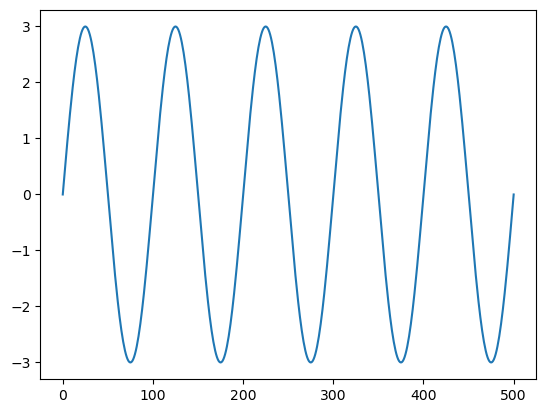

In [19]:
plt.plot(toy_problem(5))
plt.show()

 - sin_dataset: 새로운 데이터를 모델에 입력하기 위해 Dataset를 정의합니다. 
 
 - prepare_data: 입력은 n, T, alpha를 받습니다. 출력은 sin 함수의 연속된 값을 5개씩으로 데이터를 만들고 이에 대한 label을 sin함수의 6번째 값으로 지정합니다. 

In [20]:
class sin_dataset(data.Dataset):
    def __init__(self, r_data, label):
        self.r_data = r_data.unsqueeze(-1)
        self.label = label
    
    def __len__(self):
        return len(self.r_data)# 데이터의 개수를 반환하시오
    
    def __getitem__(self,index):
        return self.r_data[index], self.label[index]# 주어진 index의 데이터값과 레이블값을 반환하시오

def prepare_data(n,T, alpha=0):
    target = toy_problem(n=n, T=T, amp=3, alpha=0)
    plt.plot(target)
    plt.show()
    
    rd = []
    labels = []
    
    for i in range(T*n - 5):
        rd.append(target[i:i+5]) #연속된 5개의 값을 하나의 데이터로 입력하시오)
        labels.append(target[i+5]) # 6번째 값을 label로 하시오)
    
    return torch.Tensor(rd), torch.Tensor(labels)


- train, validation, test 데이터셋을 만들고 이를 DataLoader에 입력합니다. 

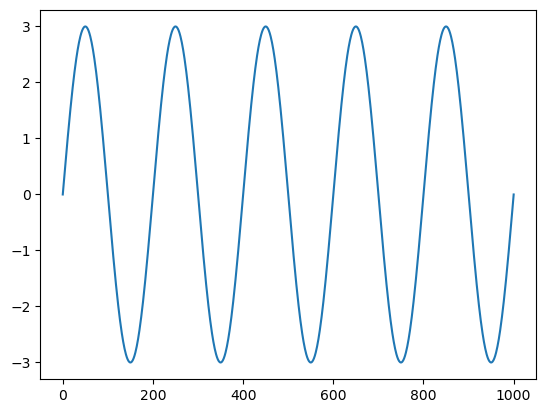

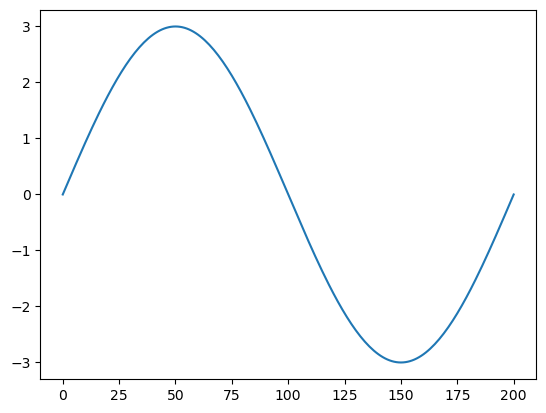

In [21]:
BATCH_SIZE = 10
T = 200
n = 5

pre_train = prepare_data(n,T)
pre_test = prepare_data(int(n/4),T,n+1)

train = sin_dataset(*pre_train) # 위 결과를 알맞게 입력하시오)
test = sin_dataset(*pre_test) # 위 결과를 알맞게 입력하시오)


train, val = data.random_split(train, [int(0.7 * len(train)), len(train) - int(0.7 * len(train))])
# training 데이터의 70%를 학습하는데 사용하고 나머지 30%를 Validation 데이터로 사용하시오)

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=BATCH_SIZE, shuffle=False)


# 4.모델 만들기


아래의 모델에서 many-to-one RNN 모델을 만들어봅시다.

 - RNN의 Hidden Unit의 수는 100으로 하세요
 
 - RNN의 입력의 크기는 5개입니다. 즉, 5개의 입력값으로 6번째 값을 예측해 봅시다.
 
 - 활성화 함수는 ReLU로 하세요.

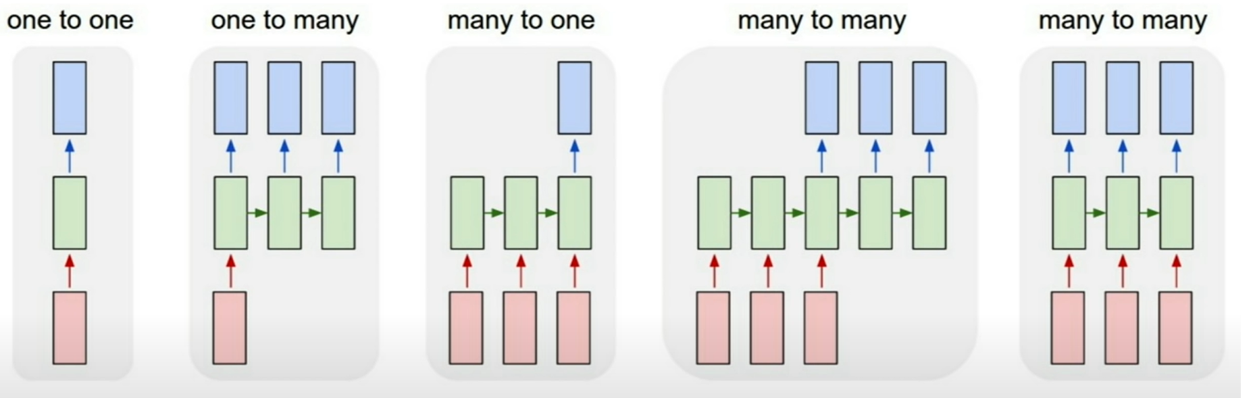

In [48]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        
        # RNN 모델을 만드시오
        self.rnn = nn.RNN(
            input_size=1,    
            hidden_size=100, 
            num_layers=1,    
            batch_first=True 
        )

        self.linear = nn.Linear(100, 1)  
        self.relu = nn.ReLU()            

    def forward(self,x,h_state):
        
        # RNN 모델을 만드시오
        h_out, h_state = self.rnn(x, h_state)
        h_out = self.relu(h_out)       
        out = self.linear(h_out[:,-1,:]) 
        return out[:,-1].squeeze() # 마지막 RNN 층의 출력값만 사용함

## 7. 학습 준비하기

1) 1 epoch를 학습할 수 있는 함수 만들기

2) Test와 Validation data의 정확도 계산할 수 있는 함수 만들기

In [49]:
def training_epoch(train_loader, network, loss_func, optimizer, epoch):
    train_losses = []
    train_correct = 0
    log_interval = 300
    
    for batch_idx, (r_data, label) in enumerate(train_loader):
        r_data, label = r_data.to(device), label.to(device)

        # 미분값의 초기화
        optimizer.zero_grad()
        # 채우시오

        # Forward propagration 계산하기.
        init_h = torch.zeros(1, r_data.size(0), 100).to(device) # 초기값을 0으로 채우시오
        outputs = network(r_data, init_h)# 채우시오
        
        
        # MSE 함수를 적용하여 loss를 구하고 저장하기
        loss = loss_func(outputs, label) # 채우시오
        train_losses.append(loss.item())

        # Gradinet 구하기
        loss.backward()
        # 채우시오

        # weight값 update 하기
        optimizer.step()
        # 채우시오

        # 학습 상황 출력
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.2f}%)]\tLoss: {:.6f}'
                  .format(epoch, batch_idx * len(label), len(train_loader.dataset),100. * batch_idx / len(train_loader),
                          loss.item()))
            
    return train_losses

In [50]:
def test_epoch(test_loader, network, loss_func, val = False):
    correct = 0
    
    test_losses = []
    
    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(test_loader):
            image, label = image.to(device), label.to(device)

            # Forward propagration 계산하기.
            init_h = torch.zeros(1, image.size(0), 100).to(device) # 채우시오
            outputs = network(image, init_h)# 채우시오

            # MSE 함수를 적용하여 loss를 구하기
            loss = loss_func(outputs, label)
            test_losses.append(loss.item())


        #중간결과 출력
        if val is True:
            print('Validation set: Loss: {:.5f}\n'.format(loss))
        
        else:
            print('Test set: Loss: {:.5f}\n'.format(loss))
        
    return test_losses


## 8. 위 정의된 함수로 학습 함수 만들기

- Adam Optimizer를 사용하여 학습시키기

- MSELoss() 함수를 사용할 것

In [51]:
def training(network, learning_rate = 0.001):
    
    epoches = 100
    
    cls_loss = nn.MSELoss() # 채우시오
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)# 채우시오
    
    train_losses_per_epoch = []
    test_losses_per_epoch = []
  
    for epoch in range(epoches):
                
        # 모델를 학습 중이라고 선언하기
        network.train()
        
        train_losses = training_epoch(train_loader,network,cls_loss,optimizer, epoch)
        
        # epoch 별로 loss 평균값, 정확도 구하기
        average_loss = np.mean(train_losses)
        train_losses_per_epoch.append(average_loss)
        
        
        # epoch 별로 정확도 출력
        print('\nTraining set: Loss {:.6f}'.format(average_loss))

        
        ### 학습 중에 test 결과 보기
        
        # 모델 test 중인 것을 선언하기
        network.eval()
        
        correct = 0
        with torch.no_grad():
            test_losses = test_epoch(train_loader, network, cls_loss, True)

        test_losses_per_epoch.append(np.mean(test_losses))
        
    with torch.no_grad():
        test_losses = test_epoch(test_loader, network, cls_loss, False)
        
    return train_losses_per_epoch, test_losses_per_epoch


In [52]:
model = RNN()# 채우시오
train_loss, test_loss = training(model)# 채우시오

Train Epoch: 0 [0/696 (0.00%)]	Loss: 5.507725

Training set: Loss 1.141221
Validation set: Loss: 0.21055

Train Epoch: 1 [0/696 (0.00%)]	Loss: 0.222283

Training set: Loss 0.101281
Validation set: Loss: 0.04123

Train Epoch: 2 [0/696 (0.00%)]	Loss: 0.041484

Training set: Loss 0.056001
Validation set: Loss: 0.03908

Train Epoch: 3 [0/696 (0.00%)]	Loss: 0.031108

Training set: Loss 0.045890
Validation set: Loss: 0.02982

Train Epoch: 4 [0/696 (0.00%)]	Loss: 0.024616

Training set: Loss 0.033222
Validation set: Loss: 0.02134

Train Epoch: 5 [0/696 (0.00%)]	Loss: 0.027160

Training set: Loss 0.022447
Validation set: Loss: 0.01806

Train Epoch: 6 [0/696 (0.00%)]	Loss: 0.033416

Training set: Loss 0.015023
Validation set: Loss: 0.01292

Train Epoch: 7 [0/696 (0.00%)]	Loss: 0.020978

Training set: Loss 0.011279
Validation set: Loss: 0.00880

Train Epoch: 8 [0/696 (0.00%)]	Loss: 0.012813

Training set: Loss 0.008651
Validation set: Loss: 0.00560

Train Epoch: 9 [0/696 (0.00%)]	Loss: 0.009939


Train Epoch: 78 [0/696 (0.00%)]	Loss: 0.000171

Training set: Loss 0.000508
Validation set: Loss: 0.00104

Train Epoch: 79 [0/696 (0.00%)]	Loss: 0.000454

Training set: Loss 0.000797
Validation set: Loss: 0.00312

Train Epoch: 80 [0/696 (0.00%)]	Loss: 0.001911

Training set: Loss 0.001302
Validation set: Loss: 0.00058

Train Epoch: 81 [0/696 (0.00%)]	Loss: 0.000420

Training set: Loss 0.001576
Validation set: Loss: 0.00008

Train Epoch: 82 [0/696 (0.00%)]	Loss: 0.000069

Training set: Loss 0.000794
Validation set: Loss: 0.00022

Train Epoch: 83 [0/696 (0.00%)]	Loss: 0.000176

Training set: Loss 0.000381
Validation set: Loss: 0.00010

Train Epoch: 84 [0/696 (0.00%)]	Loss: 0.000107

Training set: Loss 0.000234
Validation set: Loss: 0.00019

Train Epoch: 85 [0/696 (0.00%)]	Loss: 0.000100

Training set: Loss 0.000296
Validation set: Loss: 0.00010

Train Epoch: 86 [0/696 (0.00%)]	Loss: 0.000119

Training set: Loss 0.000379
Validation set: Loss: 0.00028

Train Epoch: 87 [0/696 (0.00%)]	Loss:

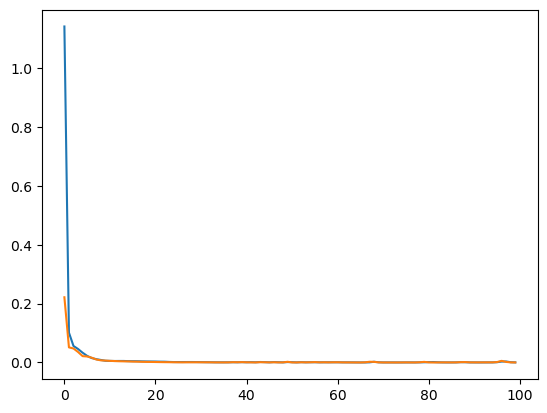

In [53]:
plt.plot(train_loss)
plt.plot(test_loss)

 ## 9. RNN함수가 얼마나 잘 학습 되었는지 확인해 봅시다.
 
  - 초기값은 sin함수 1주기 후 마지막 5개 값으로 하고 
  
  - 이를 바탕으로 6번째 예측을 한 후 
  
  - 다시 새롭게 추가된 값으로부터 마지막 5개를 새로운 입력으로 하여
  
  - 100 번째 값까지 예측해봅시다. 

In [54]:
init_test = toy_problem(1,T, amp=3)
init_test = torch.tensor(init_test[-5:].reshape(1,5,1), dtype=torch.float).cpu()

/Users/seoyoung/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


2020125046


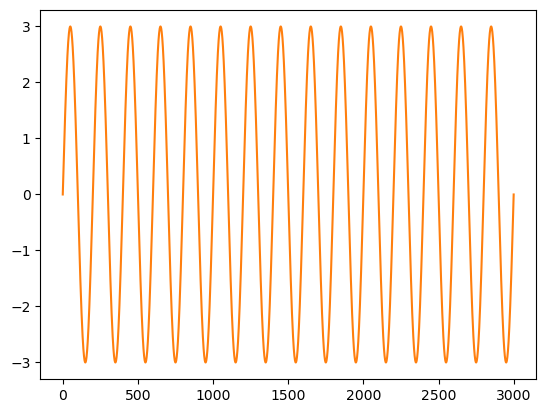

In [55]:
h_state = torch.zeros(1,1,100).cpu()


for i in range(3000):
    model = model.cpu()
    init_test = torch.tensor(init_test[-5:].reshape(1,5,1)).to(device) # 채우시오
    r = model(init_test, h_state).clone().detach().item() # 채우시오).clone().detach().item()
    
    init_test = np.concatenate((init_test.clone().detach().numpy().squeeze(),r),axis=None)

    
plt.plot(init_test[5:])
print(2020125046)
plt.plot(toy_problem(15,T,amp=3))

## 10. 잘 예측이 됩니까? 안된다면 이유가 무엇일까요? 사인함수의 예측에 RNN 모델을 사용하는 것이 좋은 선택일까요?

정답) 좋은 것 같다. 시계열 데이터를 처리하는데 좋기 때문에 시간에 따라 변화하느 사인 함수 예측에 적합하다

In [56]:
print("이서영 2020125046")

이서영 2020125046
